In [3]:
#Importing required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
import re
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
#Importing Train File 
train_df = pd.read_csv('D://College//Northeastern_DS//DS_5500_Capstone//Data_set//train_file//train.csv')
train_df = train_df[:100000]

C:\Users\prati\AppData\Local\Temp\ipykernel_41112\3790796749.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('D://College//Northeastern_DS//DS_5500_Capstone//Data_set//train_file//train.csv')


In [5]:
#Importing Test File 
test_df = pd.read_csv('D://College//Northeastern_DS//DS_5500_Capstone//Data_set//test_file//test.csv')
test_df = test_df[:100000]

C:\Users\prati\AppData\Local\Temp\ipykernel_41112\2189940157.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('D://College//Northeastern_DS//DS_5500_Capstone//Data_set//test_file//test.csv')


In [6]:
#Reduction of Memory Usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
#Function to remove columns based on conditions
def remove_columns(df):
    cols_to_keep = []
    for col in df.columns:
        if ((df[col].isna().sum()/len(df)))<0.5:
            #print(col, (train_df[col].isna().sum()/len(train_df)))
            cols_to_keep.append(col)
            #print('+++++++')
    df = df[cols_to_keep]
    
    #Removing the columns which are values less than 20%
    cols_to_keep_2 = []
    for col in df.columns:
        if len(df[col].value_counts())<20:
            #print(col, len(train_df[col].value_counts()))
            cols_to_keep_2.append(col)
    df = df[cols_to_keep_2]
            #print()
    return df

In [8]:
#Function to replace values for NA
def replace_values(df):
    mean_value = df['RtpStateBitfield'].describe()['50%']
    df['RtpStateBitfield'].fillna(value=mean_value, inplace=True)
    mean_value = df['Wdft_RegionIdentifier'].describe()['50%']
    df['Wdft_RegionIdentifier'].fillna(value=mean_value, inplace=True)
    return df

In [9]:
#Function to get dummies
def get_dummies(df):
    df = pd.get_dummies(df,columns=df.columns.tolist())
    return df

In [10]:
#Function to make columns equal
def make_columns_equal(train_df,test_df):
    
    set1 = set(train_df.columns.tolist())
    set2 = set(test_df.columns.tolist())
    
    col1 = list(set1 - set2) # in train not in test
    col2 = list(set2 - set1) # in test not in train
    
    #Adding columns with '0' values which are not in test but in train
    if len(col1) != 0:
        for col in col1:
            test_df[col] = 0
        
    #Removing columns from test which are not in train
    if len(col1) != 0:
        for col in col2:
            test_df.drop([col],axis=1,inplace=True)
    
    return train_df,test_df

In [11]:
#Creating a copy for train_df
train_df_1 =  train_df.copy(deep=True)

In [12]:
#Reducing train_df
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 33.57 Mb (47.0% reduction)


In [13]:
#Reducing test_df
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 33.47 Mb (46.5% reduction)


In [14]:
#Removing HasDetections column from train file
target = train_df['HasDetections']
train_df.drop(['HasDetections'],axis=1,inplace=True)

In [15]:
#Removing unwanted columns based on conditions
train_df = remove_columns(train_df)
test_df = remove_columns(test_df)

In [16]:
#Removing unwanted  columns with least correlation from train df
removable_columns = ['IsBeta','Census_IsFlightsDisabled','AutoSampleOptIn','SMode',
                     'Census_IsPortableOperatingSystem','Census_DeviceFamily','UacLuaenable',
                     'Census_IsVirtualDevice','Platform']
train_df.drop(removable_columns, axis=1, inplace=True)

In [17]:
#Removing unwanted  columns with least correlation from test df
removable_columns = ['IsBeta','Census_IsFlightsDisabled','AutoSampleOptIn',
                     'Census_IsPortableOperatingSystem','Census_DeviceFamily','UacLuaenable',
                     'Census_IsVirtualDevice','Platform']
test_df.drop(removable_columns, axis=1, inplace=True)

In [18]:
#Calling the replace values
train_df = replace_values(train_df)
test_df = replace_values(test_df)

In [19]:
#Making the columns same of the test df as that of train df
#test_df = test_df[train_df.columns.tolist()]

In [20]:
#Calling get dummies function
train_df = get_dummies(train_df)
test_df = get_dummies(test_df)

In [21]:
#Removing the columns from test_df which are unwanted and not present in the train_df
train_df,test_df = make_columns_equal(train_df,test_df)

In [22]:
#renaming column names since it creates issues in light gbm
train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [41]:
#Assigning the parameters for light GBM 
features = list(train_df.columns)

lgb_params = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.09, #0.09 new
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1, #1
         "bagging_fraction": 0.9,#0.9 original
         "bagging_seed": 42,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1 }

folds = KFold(n_splits=10, shuffle=True, random_state=42)
oof_lgb = np.zeros(len(train_df))
predictions_lgb = np.zeros(len(test_df))

In [59]:
#Light GBM function call
evals_result = {}
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=150,
                    callbacks=[lgb.record_evaluation(evals_result)])
    
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.733723	valid_1's auc: 0.690076
[200]	training's auc: 0.762998	valid_1's auc: 0.689172
Early stopping, best iteration is:
[93]	training's auc: 0.731223	valid_1's auc: 0.690203
-
Fold 2


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.735175	valid_1's auc: 0.681477
[200]	training's auc: 0.763692	valid_1's auc: 0.678508
Early stopping, best iteration is:
[69]	training's auc: 0.7229	valid_1's auc: 0.682314
-
Fold 3


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.733503	valid_1's auc: 0.678165
[200]	training's auc: 0.76292	valid_1's auc: 0.677851
Early stopping, best iteration is:
[98]	training's auc: 0.73279	valid_1's auc: 0.678323
-
Fold 4


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.733824	valid_1's auc: 0.67586
[200]	training's auc: 0.762699	valid_1's auc: 0.67383
Early stopping, best iteration is:
[114]	training's auc: 0.738878	valid_1's auc: 0.67621
-
Fold 5


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.734391	valid_1's auc: 0.68039
[200]	training's auc: 0.763507	valid_1's auc: 0.678349
Early stopping, best iteration is:
[54]	training's auc: 0.715927	valid_1's auc: 0.68162
-
Fold 6


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.734895	valid_1's auc: 0.679661
Early stopping, best iteration is:
[28]	training's auc: 0.700299	valid_1's auc: 0.682879
-
Fold 7


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.734407	valid_1's auc: 0.674828
[200]	training's auc: 0.763695	valid_1's auc: 0.671359
Early stopping, best iteration is:
[88]	training's auc: 0.730052	valid_1's auc: 0.675224
-
Fold 8


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.735037	valid_1's auc: 0.669653
[200]	training's auc: 0.76325	valid_1's auc: 0.666743
Early stopping, best iteration is:
[121]	training's auc: 0.741929	valid_1's auc: 0.669955
-
Fold 9


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.734093	valid_1's auc: 0.675585
[200]	training's auc: 0.76369	valid_1's auc: 0.673532
Early stopping, best iteration is:
[63]	training's auc: 0.719904	valid_1's auc: 0.675912
-
Fold 10


C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\prati\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.734402	valid_1's auc: 0.68215
[200]	training's auc: 0.763408	valid_1's auc: 0.68123
Early stopping, best iteration is:
[76]	training's auc: 0.725393	valid_1's auc: 0.682551


In [46]:
#Convert prediction values into binary  for the predictions of 'HasDetections' column for the validation set
y_pred = []
for i in range(len(oof_lgb)):
    if oof_lgb[i]>=.5:       # setting threshold to .5
        y_pred.append(1)
    else:  
        y_pred.append(0)

In [47]:
#Showing the validation dataset
oof_lgb

array([0.51346745, 0.62598391, 0.54195459, ..., 0.33110412, 0.32847675,
       0.4096812 ])

In [48]:
#Showing the predictions of the test_df
predictions_lgb

array([0.49565008, 0.63758604, 0.46727461, ..., 0.82468542, 0.28641013,
       0.40624459])

In [49]:
#Showing Predictions and HasDetections for train data set
train_df_1['Predictions'] = y_pred
train_df_1[['MachineIdentifier','HasDetections','Predictions']]

MachineIdentifier  HasDetections  Predictions
0      0000028988387b115f69f31a3bf04f09              0            1
1      000007535c3f730efa9ea0b7ef1bd645              0            1
2      000007905a28d863f6d0d597892cd692              0            1
3      00000b11598a75ea8ba1beea8459149f              1            1
4      000014a5f00daa18e76b81417eeb99fc              1            1
...                                 ...            ...          ...
99995  02e11f9b051950ba19ef87553f24b3d2              0            0
99996  02e11ff750f98912e9073afe15bf5018              1            1
99997  02e120fd73a9b3981b80a879f1d94729              0            0
99998  02e123408acf92064932e0900a42667b              0            0
99999  02e125f54e5e4aefc7a42cae452fe9b2              0            0

[100000 rows x 3 columns]

In [29]:
#Finally we are appending predicted values to test_df
test_df['Pred_HasDetections'] = predictions_lgb

In [30]:
test_df

ProductName_mse  ProductName_win8defender  RtpStateBitfield_00  \
0                    0                         1                    0   
1                    0                         1                    0   
2                    0                         1                    0   
3                    0                         1                    0   
4                    0                         1                    0   
...                ...                       ...                  ...   
99995                0                         1                    0   
99996                0                         1                    0   
99997                0                         1                    0   
99998                0                         1                    0   
99999                0                         1                    0   

       RtpStateBitfield_10  RtpStateBitfield_30  RtpStateBitfield_50  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
99995                    0                    0                    0   
99996                    0                    0                    0   
99997                    0                    0                    0   
99998                    0                    0                    0   
99999                    0                    0                    0   

       RtpStateBitfield_70  RtpStateBitfield_80  IsSxsPassiveMode_0  \
0                        1                    0                   1   
1                        1                    0                   1   
2                        1                    0                   1   
3                        1                    0                   1   
4                        1                    0                   1   
...                    ...                  ...                 ...   
99995                    1                    0                   1   
99996                    1                    0                   1   
99997                    1                    0                   1   
99998                    1                    0                   1   
99999                    1                    0                   1   

       IsSxsPassiveMode_1  ...  Census_ProcessorCoreCount_480  OsVer_6130  \
0                       0  ...                              0           0   
1                       0  ...                              0           0   
2                       0  ...                              0           0   
3                       0  ...                              0           0   
4                       0  ...                              0           0   
...                   ...  ...                            ...         ...   
99995                   0  ...                              0           0   
99996                   0  ...                              0           0   
99997                   0  ...                              0           0   
99998                   0  ...                              0           0   
99999                   0  ...                              0           0   

       Census_ProcessorCoreCount_320  Census_ProcessorCoreCount_100  \
0                                  0                              0   
1                                  0                              0   
2                                  0                              0   
3                                  0                              0   
4                                  0                              0   
...                              ...                         

In [50]:
#Getting accuracy for the validation set
accuracy=accuracy_score(y_pred,target)
print('Accuracy on the Training Set is ',accuracy*100,'%')

Accuracy on the Training Set is  62.498 %


In [51]:
#Calculating F1 score
print('F1-Score for the Training Set is ',f1_score(target, y_pred, average='macro'))

F1-Score for the Training Set is  0.6245805295063809


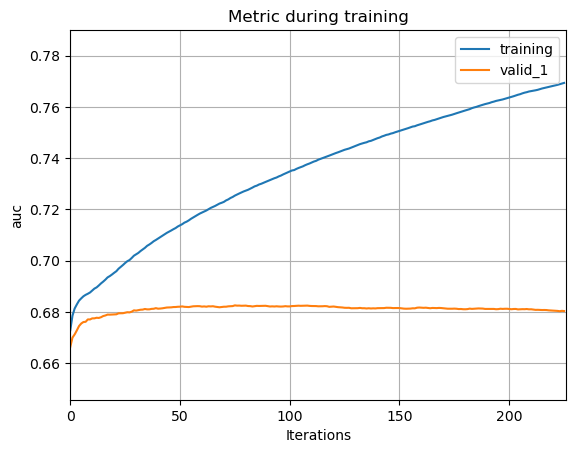

In [54]:
#Some Visualization
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()